In [1]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 2

# Computing of Geodesics on a Mesh

In this post I will exhibit two way of approximate geodesics between two points. A linear way and a 2nd order approximation. <br/>
**Important:** this method is only as good as it's distance function. 

Both these methods requires a distance function, the distance function will be calculated in two different ways, namely the heat method is used as described in [Geodesics in Heat](https://www.cs.cmu.edu/~kmcrane/Projects/HeatMethod/), and the Fast Marching Method as described in [Computing geodesic paths on manifolds](http://www.pnas.org/cgi/doi/10.1073/pnas.95.15.8431).  Geodesics can then be computed using gradient descent. The method does not require a distance function over the entire manifold, in case we only want to find small geodesics. In the linear case the gradient is constant on each triangle, the path is then constructed by finding interections with the edge. A bit more details below. 

In the second order approximation, there is a constant transition between the manifold and charts. These charts are 2 dimensional representation of a vertex and its neighbors. In this flat space we find a second order approximation of the distance function, the computed 2 dimensional points are then translated back to the manifold. 

In the linear case points are only computed on the edges of faces, while in the second order the path also consists of points on the faces. 

The creation of these charts and the translation between the charts and the manifold are done in the `trimesh` object. This object consists of additional attributes and functions that could be usefull.

----

Some preliminairy function and packages

In [2]:
import vtki
import numpy as np

from modules.heat_method import heat_method
from modules.fast_marching_method import FMM
from modules.geometry_functions import discrete_gradient
from modules.trimesh import trimesh

from modules.gradient_walk.linear_walk import LinearWalk
from modules.gradient_walk.quadratic_walk import QuadraticWalk
from plyfile import PlyData, PlyElement
from vtki import PolyData

In [3]:
def read_ply(f_name):
    # Read the vertices and triangles from a ply file
    data = PlyData.read(f_name)
    
    data_vert = np.vstack([list(vertex) for vertex in data['vertex'].data])
    data_tri = np.vstack(data['face'].data['vertex_indices'])
    return data_vert, data_tri

color_map = 'prism'
color_point = 'black'
def vtki_plot(mesh,ind, color, cmap = color_map, arrows_tri = [], paths = [], text = '', inline = False, show_edges = True):
    # Plot functions on the mesh, together with arrows
    polydata = PolyData(mesh.vertices, np.c_[[[3]]*len(mesh.triangles),mesh.triangles])
    if inline:
        plotter = vtki.Plotter(notebook = True)
    else:
        plotter = vtki.BackgroundPlotter()

    plotter.add_mesh(polydata, scalars = color, cmap = cmap, show_edges = show_edges)
    plotter.add_text(text)
    
    if len(paths) > 0 :
            for pa in paths:
                p = np.array(pa['points'])
                if len(p) > 0:
                    plotter.add_lines(p, width = 10, color = 'white')
    
    if len(ind)> 0:
        plotter.add_points(mesh.vertices[ind], point_size = 20, color = 'black')

    if len(arrows_tri) > 1:
        cent = mesh.vertices[mesh.triangles].mean(1)
        plotter.add_arrows(cent, arrows_tri, mag  = .01, color = 'g')
    plotter.view_xy()
    plotter.show()    



Reading in the data

In [4]:
torus_vert, torus_tri = read_ply('../test_data/torus_24k.ply')
torus = trimesh(torus_vert, torus_tri)

In [5]:
arm_vert, arm_tri = read_ply('../test_data/armadillo_172k.ply')
armadillo = trimesh(arm_vert, arm_tri)

# Linear walk.

This works using a predefined vector field on the triangles. In the case that the gradient of a vertex is required, the gradients of the adjacend triangles are mapped to the chart around that vertex, then a average is taken of thos vector, the resulting vector is then mapped back to the manifold. 

Giving a start point we have a gradient and then we calculate the interection with the opposing edge. The next face has a new gradient which is used to calculate the new point. 

A few edge (no pun inteded) cases. 
- If the new gradient points towards the previous face we walk along the current edge in the directing of the gradient projected on the edge. Similarly when we find ourselves on the boundary. 
- If we find an intersection with an edge that is close by an vertex then the next point will be that vertex. Close defined by the `np.allclose()` function.

We use as stopping criteria the faces around the origin. 

In [6]:
# Init the heat method
heat_torus = heat_method(torus_vert,torus_tri)
fmm_torus = FMM(torus)

# Just some points
left_ind = np.argmin(torus_vert[:,2])
right_ind = np.argmax(torus_vert[:,2])

In [7]:
# Run the heat method
d_heat, X_heat = heat_torus.run(left_ind)

In [8]:
# Run the Fast marching, this method takes longer than the heat method.
d_fmm = fmm_torus.run([left_ind])

In [9]:
Lwalk = LinearWalk(torus)
path_heat = Lwalk.run(left_ind, right_ind, d_heat , max(d_heat))
path_fmm = Lwalk.run(left_ind, right_ind, d_fmm , max(d_fmm))

In [10]:
# Uncomment this to plot it in a seperate window
#vtki_plot(torus, [left_ind, right_ind], d_fmm, paths = [path_fmm])

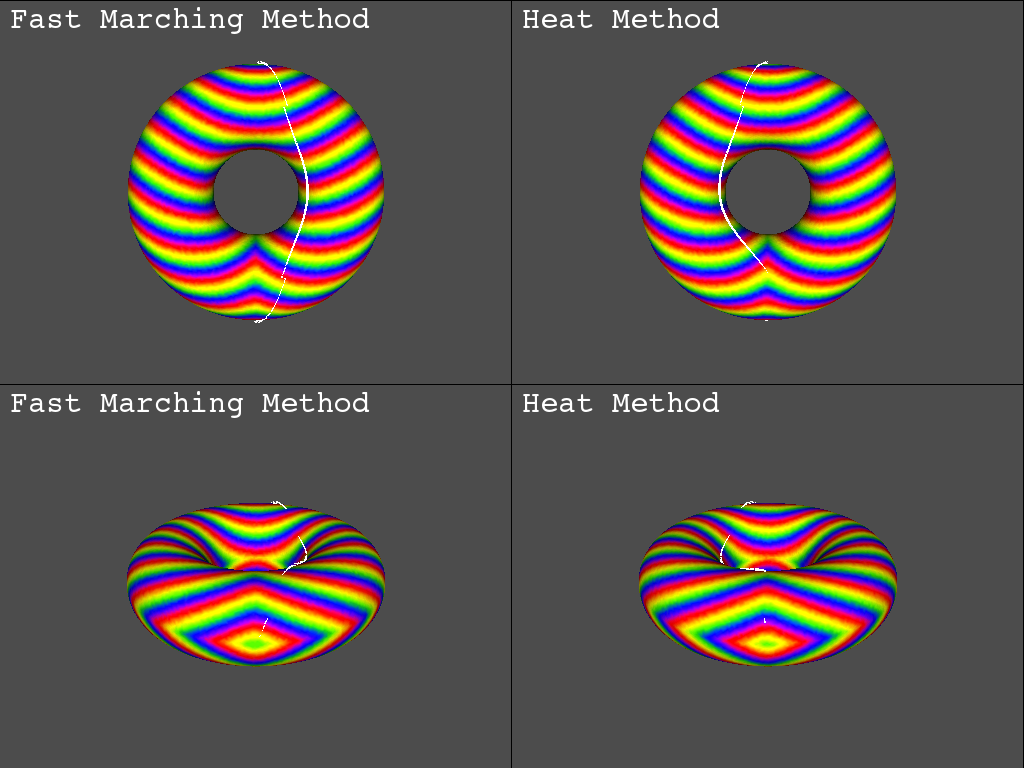

In [11]:
plotter = vtki.Plotter(shape=(2, 2))

polydata = PolyData(torus_vert, np.c_[[[3]]*len(torus_tri),torus_tri])
color_map = 'prism'

plotter.subplot(0,0)
plotter.add_text('Fast Marching Method', position=None, font_size=30)
plotter.add_mesh(polydata, scalars = d_fmm, cmap = color_map)
plotter.add_lines(np.array(path_fmm['points']), width = 5, color = 'white')
plotter.view_vector([0,1,0], viewup = [0,0,-1])


plotter.subplot(0, 1)
plotter.add_text('Heat Method', font_size=30)
plotter.add_mesh(polydata, scalars = d_heat, cmap = color_map)
plotter.add_lines(np.array(path_heat['points']), width = 5, color = 'white')
plotter.view_vector([0,1,0], viewup = [0,0,-1])

plotter.subplot(1,0)
plotter.add_text('Fast Marching Method', position=None, font_size=30)
plotter.add_mesh(polydata, scalars = d_fmm, cmap = color_map)
plotter.add_lines(np.array(path_fmm['points']), width = 5, color = 'white')
plotter.view_vector([0,.5,1], viewup = [0,1,-.5])


plotter.subplot(1, 1)
plotter.add_text('Heat Method', font_size=30)
plotter.add_mesh(polydata, scalars = d_heat, cmap = color_map)
plotter.add_lines(np.array(path_heat['points']), width = 5, color = 'white')
plotter.view_vector([0,.5,1], viewup = [0,1,-.5])



plotter.show()

First of all the paths do not look like they are connected, but that is the plotting program that has an issue. Plotting it in a seperate window makes it better visible. Although the distance function of the heat and fast marching method look similar, they produce different paths. The Fast Marching seems to give a more accurate account, there seems to be a symmetry in the $z$-plance. The heat method is missing this. Granted we are querring a point close to the cut locus. From here it has trouble deciding whether to go left of right of the hole. 


# Quadratic walk

For a second order walk, which will look smoother, but will be slower to compute. 

Given a point on the manifold on a face, one of the three vertices of that face will serve as the origin of that chart. Which point that is is based on a barycentric coordinates. In this chart, the algorithm uses a second order approximation together with Heun iteration method to calculate next points on the path. Checks are made to verify to see when other chart would be better. This method is described in [Computing geodesic paths on manifolds](http://www.pnas.org/cgi/doi/10.1073/pnas.95.15.8431) section 5. 

A potential downside to this method is that the approximation of the distacne function on a chart has a local minimum, meaning that the found path will not converge to the actual minimum. This approximation might falter when the distance function is not a good estimation of the true distance or when the number of neighbors is too few.

In [12]:
heat_func = {i: d_heat[i] for i in range(len(d_heat))}
fmm_func = {i: d_fmm[i] for i in range(len(d_fmm))}

In [13]:
QWalk = QuadraticWalk(torus)

In [14]:
%%time
qpath_heat = QWalk.run(left_ind,right_ind, heat_func, max(d_heat), step_size = 0.1)
qpath_fmm = QWalk.run(left_ind, right_ind, fmm_func, max(d_fmm), step_size = .1)

CPU times: user 2.35 s, sys: 228 ms, total: 2.58 s
Wall time: 2.21 s


In [15]:
#vtki_plot(torus, [left_ind,right_ind], d, paths = [qpath], text = 'both')

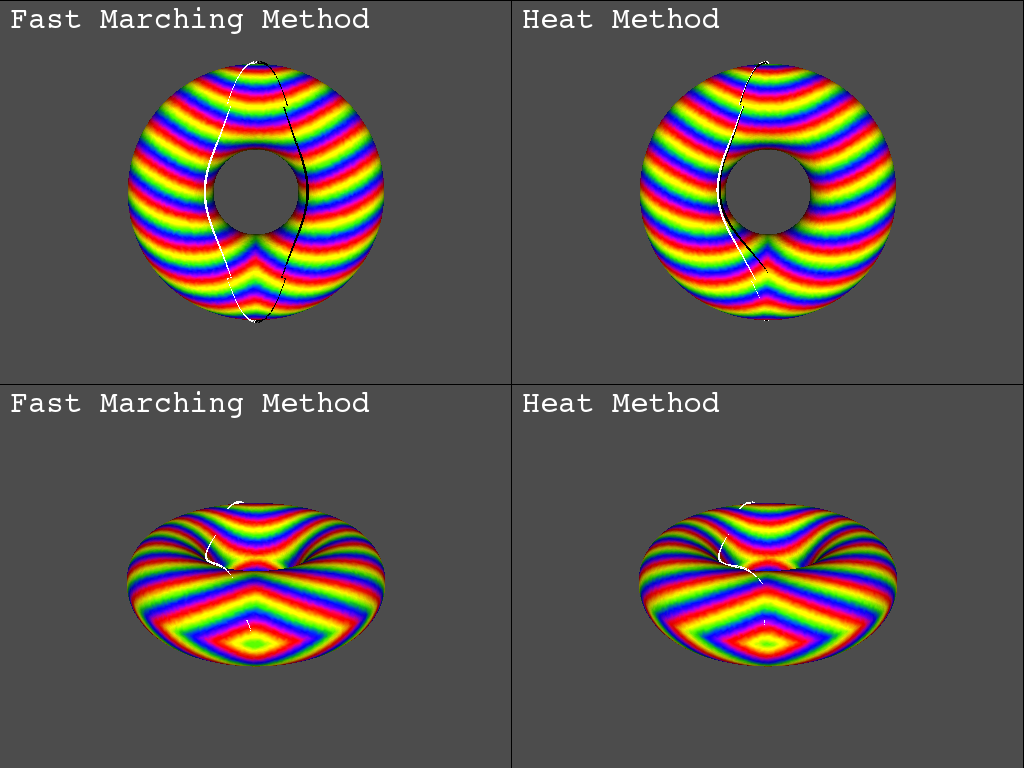

In [16]:
plotter = vtki.Plotter(shape=(2, 2))

polydata = PolyData(torus_vert, np.c_[[[3]]*len(torus_tri),torus_tri])
color_map = 'prism'

plotter.subplot(0,0)
plotter.add_text('Fast Marching Method', position=None, font_size=30)
plotter.add_mesh(polydata, scalars = d_fmm, cmap = color_map)
plotter.add_lines(np.array(qpath_fmm['points']), width = 5, color = 'white')
plotter.add_lines(np.array(path_fmm['points']), width = 5, color = 'black')
plotter.view_vector([0,1,0], viewup = [0,0,-1])


plotter.subplot(0, 1)
plotter.add_text('Heat Method', font_size=30)
plotter.add_mesh(polydata, scalars = d_heat, cmap = color_map)
plotter.add_lines(np.array(qpath_heat['points']), width = 5, color = 'white')
plotter.add_lines(np.array(path_heat['points']), width = 5, color = 'black')
plotter.view_vector([0,1,0], viewup = [0,0,-1])

plotter.subplot(1,0)
plotter.add_text('Fast Marching Method', position=None, font_size=30)
plotter.add_mesh(polydata, scalars = d_fmm, cmap = color_map)
plotter.add_lines(np.array(qpath_fmm['points']), width = 5, color = 'white')
plotter.view_vector([0,.5,1], viewup = [0,1,-.5])


plotter.subplot(1, 1)
plotter.add_text('Heat Method', font_size=30)
plotter.add_mesh(polydata, scalars = d_heat, cmap = color_map)
plotter.add_lines(np.array(qpath_heat['points']), width = 5, color = 'white')
plotter.view_vector([0,.5,1], viewup = [0,1,-.5])



plotter.show()

The paths for the second approximation look kind of similar. The black lines are the linear approximations and the white are the quadratic.

In the FMM case the line passes the hole via the other side, but seems to be a symmetry. 

The Heat case the path seems to escape the decision boundary a bit quicker, than the linear case, but not as quick as in the fmm case. 

# Armadillo

Another example, the armadillo has somewhat more vertices. This example comes from [The Stanford 3D Scanning Repository](https://graphics.stanford.edu/data/3Dscanrep/). The distance function used here is calculated using the heat method as the fast marching method will take too long. 

In [17]:
arm_heat = heat_method(arm_vert, arm_tri)

In [18]:
origin = np.argmax(arm_vert[:,2])
dest = 2463 # some random vertex

In [19]:
d, X = arm_heat.run(origin)

In [20]:
Lwalk = LinearWalk(armadillo)
Qwalk = QuadraticWalk(armadillo)

In [21]:
path = Lwalk.run(origin, dest, d , max(d))

In [22]:
d_func = {i:d[i] for i in range(len(d))}
qpath = Qwalk.run(origin,dest, d_func , max(d), step_size = 0.01)

In [23]:
#vtki_plot(armadillo,[origin, dest], d, paths = [path, qpath], show_edges = False)

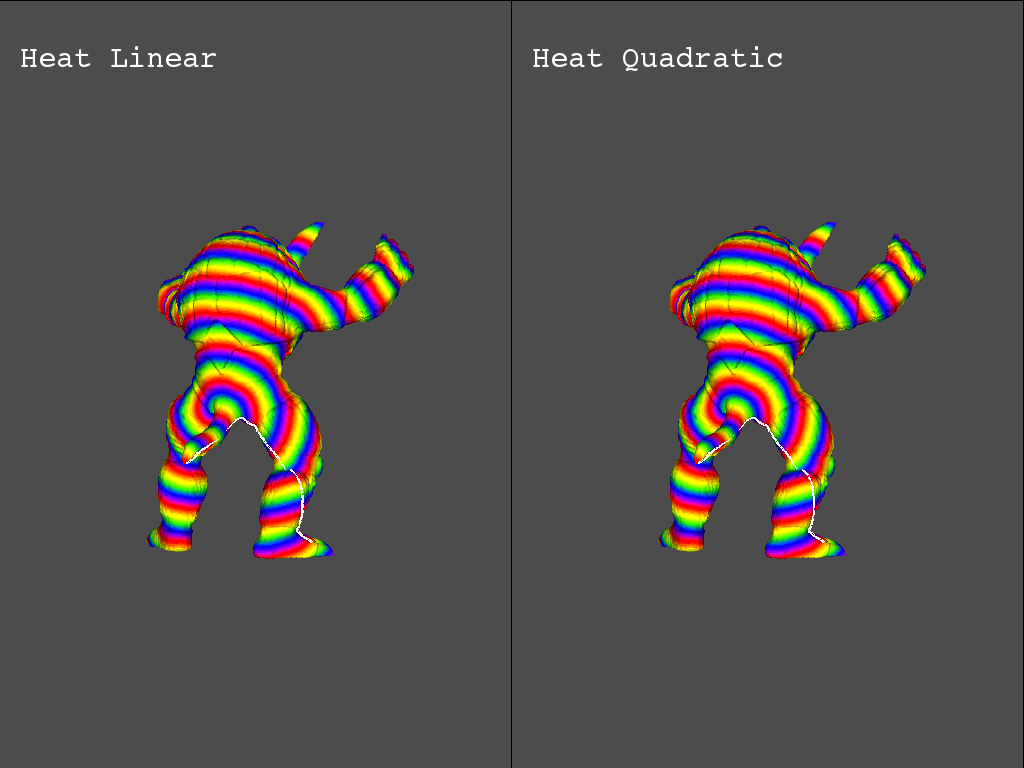

In [24]:
plotter = vtki.Plotter(shape=(1, 2))

polydata = PolyData(arm_vert, np.c_[[[3]]*len(arm_tri),arm_tri])
color_map = 'prism'

plotter.subplot(0,0)
plotter.add_text('Heat Linear', position=None, font_size=30)
plotter.add_mesh(polydata, scalars = d, cmap = color_map)
plotter.add_lines(np.array(path['points']), width = 5, color = 'white')
plotter.view_vector([.5,0,1], viewup = [0,1,0])


plotter.subplot(0, 1)
plotter.add_text('Heat Quadratic', font_size=30)
plotter.add_mesh(polydata, scalars = d, cmap = color_map)
plotter.add_lines(np.array(qpath['points']), width = 5, color = 'white')
plotter.view_vector([.05,0,.1], viewup = [0,1,0])

plotter.show()

Again in the big picture you do not see that much of a difference, once you zoom in the differences become apparent. 